In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision.models.vgg import vgg19
from torchgeo.datasets.utils import BoundingBox
from torchvision.utils import save_image, make_grid
from torchvision import transforms, utils, datasets
from torch.utils.tensorboard.writer import SummaryWriter
from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.samplers import RandomGeoSampler, PreChippedGeoSampler, GridGeoSampler

import rasterio

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from tqdm import tqdm

from PIL import Image

In [2]:
def set_seed(SEED = 456):
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True

set_seed()

In [3]:
# Clase que lee imagenes .tif que hereda de `RasterDataset`, clase de torchgeo
class Sentinel2(RasterDataset):
    filename_glob = "*.tif"
    date_format = "%Y%m%dT%H%M%S"
    is_image = True
    separate_files = True
    all_bands = ["B02", "B03", "B04", "B08"]
    rgb_bands = ["B04", "B03", "B02"]
    
    def plot(self, sample, title=""):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))

        # Reorder and rescale the image
        image = sample["image"][rgb_indices].permute(1, 2, 0)

        fig, ax = plt.subplots(figsize=(4,4))
        ax.set_title(title)
        ax.imshow(image)

        return fig
    
    def save(self, sample, name=""):
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))
        
        image = sample["image"][rgb_indices] #.permute(0, 1, 2)    
        save_image(image, path + '../images_png/' + name + ".png")

### Dataloader

In [4]:
class GlacierRock(DataLoader):
    """ GlacierRock dataset."""

    def __init__(self, path: str, transform = None) -> None:
        """
        Args:
            path (str): Ruta donde se ubican las imagenes.
        """
        super(GlacierRock).__init__()
        self.path = path
        self.transforms = transform
        self.samples = []
        
        image_list = list(os.listdir(self.path))
        
        for image in image_list:
            self.samples.append((os.path.abspath(path + '/' + image), self.label_normalize(image)))

    def __len__(self):
        return len(self.samples)

    def label_normalize(self, label):
        if label.split("_")[0] == "glaciar":
            return torch.tensor([1,0]).float()
        else:
            return torch.tensor([0,1]).float()
    
    def image_normalize(self, samples):
        return (samples/255).float()
    
    def __getitem__(self, idx):
        image = read_image(self.samples[idx][0])[:3]
        image = self.image_normalize(image)
        label = self.samples[idx][1]
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, label

### Pre-entrenando el modelo VGG19

In [5]:
class TrainingVGG19(object):
    def __init__(self, device=None, freeze=False):
        self.device = ("cuda:0" if torch.cuda.is_available() else "cpu") if device is None else device
        self.model = vgg19(weights='DEFAULT')
        self.class_names = ['Glaciar', 'Cordillera']
        self.acc = 0
        self.name_model = None
        
        if freeze:
            for param in self.model.parameters():
                  param.requires_grad = False
        
        self.model.classifier[6] = nn.Linear(self.model.classifier[6].in_features, 2) 
        self.model = self.model.to(self.device)
        
        self.criterion = nn.CrossEntropyLoss()
        self.logger = SummaryWriter('logs')
    
    def fit(self, dataloaders, dataset_sizes, learning_rate=0.00001, epochs=15):
        
        self.train_logs, self.val_logs, self.acc_train_logs, self.acc_val_logs = [], [], [], []
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        
        best_acc = 0
        bar = tqdm(range(epochs))
        step = 0
        
        for epoch in bar:
            for phase in ['train', 'test']:
                preds_total = 0
                loss = 0
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()
                
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(self.device), labels.to(self.device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        
                        _, preds = torch.max(outputs, 1, keepdim=False)
                        _, label = torch.max(labels, 1, keepdim=False)
                        
                        loss = self.criterion(outputs, labels)
                        bar.set_description('{} Loss: {:.4f} '.format(phase, loss))
                        
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                        loss += loss.item() * inputs.size(0)
                        preds_total += (preds == label).sum() 
                
                epoch_loss = loss / dataset_sizes[phase]
                epoch_acc = preds_total.double() / dataset_sizes[phase]
                
                if phase == 'train':
                    self.log_train(epoch_loss, epoch_acc, epoch)
                else:
                    self.log_val(epoch_loss, epoch_acc, epoch)
                    self.log_images(inputs, labels, epoch)

                bar.set_description('{} Loss: {:.8f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
                
                if phase == 'test' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    self.name_model = "vgg_{:.8f}.pt".format(epoch_loss)
                    torch.save(self.model.state_dict(), self.name_model)
                    
            
    def log_train(self, loss, acc , epoch):
        self.logger.add_scalar('Loss/Train', loss, epoch)
        self.train_logs.append(loss.data.cpu())
        self.logger.add_scalar('Acc/Train', acc, epoch)
        self.acc_train_logs.append(acc.data.cpu())

    def log_val(self, loss, acc , epoch):
        self.logger.add_scalar('Loss/Val', loss, epoch)
        self.val_logs.append(loss.data.cpu())
        self.logger.add_scalar('Acc/Val', acc, epoch)
        self.acc_val_logs.append(acc.data.cpu())
        
    def log_images(self, image, label, epoch):
        invTrans = transforms.Compose([transforms.Normalize(mean=[0., 0., 0.],
                                                            std=[1/0.229, 1/0.224, 1/0.225]
                                                           ),
                                       transforms.Normalize(mean=[-0.485, -0.456, -0.406],
                                                            std=[1., 1., 1.]),
                                      ])
        self.logger.add_image("{}.png".format(self.class_names[torch.argmax(label[0])]), invTrans(image[0]), epoch)


    def plot(self, title="Titulo", savefig=False):
        fig, axes = plt.subplots(1, 2, figsize=(16, 7))
        
        axes[0].plot(range(len(self.train_logs)), self.train_logs, label="Training Loss")
        axes[0].plot(range(len(self.val_logs)), self.val_logs, label="Validation Loss")
        axes[0].set_title("Loss " + title)
        axes[0].set_xlabel('Epochs')
        axes[0].set_ylabel('Loss')
        axes[0].legend()
        axes[1].plot(range(len(self.val_logs)), self.acc_val_logs, label="Validation Accuracy")
        axes[1].set_title("Accuracy " + title)
        axes[1].set_xlabel('Epochs')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()

        plt.show()

Se definen las transformaciones a realizar.

In [7]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomRotation([90, 270]),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.RandomRotation([90, 270]),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

#### Opción 1 para cargar los datos

In [8]:
from datasets import load_dataset

data = load_dataset('alkzar90/rock-glacier-dataset')

Using custom data configuration alkzar90--rock-glacier-dataset-b8ccc0c21907cfa7
Found cached dataset imagefolder (/home/chr/.cache/huggingface/datasets/alkzar90___imagefolder/alkzar90--rock-glacier-dataset-b8ccc0c21907cfa7/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


  0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
def normalize(value):
    if value == 1:
        return torch.tensor([1,0]).float()
    else:
        return torch.tensor([0,1]).float()

def transform(examples, transform_compose):
    return [
        (
            transform_compose(transforms.ToTensor()(image)),
            normalize(label)
        ) for image, label in zip(examples['image'], examples['label'])
    ]

In [10]:
image_datasets = {
    phase: transform(data[phase], data_transforms[phase]) for phase in ['train', 'test']
}

---------------------------

#### Opción 2 para cargar los datos

La estructura es la sgte:
<pre>├── <font color="#12488B"><b>test</b></font>
│   ├── <font color="#A347BA"><b>cordillera_800.png</b></font>
│   ├── <font color="#A347BA"><b>cordillera_801.png</b></font>
│   ├── <font color="#A347BA"><b>cordillera_802.png</b></font>
│   ├── <font color="#A347BA"><b>cordillera_803.png</b></font>
│   ├── <font color="#A347BA"><b>cordillera_804.png</b></font>
│   ├── <font color="#A347BA"><b>cordillera_805.png</b></font>
</pre>
<pre>└── <font color="#12488B"><b>train</b></font>
    ├── <font color="#A347BA"><b>cordillera_000.png</b></font>
    ├── <font color="#A347BA"><b>cordillera_001.png</b></font>
    ├── <font color="#A347BA"><b>cordillera_002.png</b></font>
    ├── <font color="#A347BA"><b>cordillera_003.png</b></font>
    ├── <font color="#A347BA"><b>cordillera_004.png</b></font>
    ├── <font color="#A347BA"><b>cordillera_005.png</b></font>
</pre>
- Todos los archivos de `cordillera_train.rar` y `glaciares_train.rar` se van a la carpeta train.
- Todos los archivos de `cordillera_val.rar` y `glaciares_val.rar` se van a test.

In [4]:
path = "/capeta/nuevos/datos/"

In [131]:
image_datasets = {
    phase: GlacierRock(path + phase, data_transforms[phase]) for phase in ['train', 'test']
}

In [132]:
dataset_sizes = {
    x: len(image_datasets[x]) for x in ['train', 'test']
}

------------------------

Se crea el dataloader para el conjunto de train y test

In [133]:
dataloaders = {
    phase: torch.utils.data.DataLoader(
        image_datasets[phase], 
        batch_size=64,
        shuffle=True
    ) for phase in ['train', 'test']
}

In [162]:
epochs = 3
learning_rate = 0.00005
device = 'cuda:0'

In [163]:
rg_model = TrainingVGG19(freeze=False)

La clase `TrainingVGG19` creará una carpeta /logs donde guardará métricas e imágenes del entrenamiento.

In [164]:
rg_model.fit(dataloaders, dataset_sizes, learning_rate=learning_rate, epochs=epochs)

test Loss: 0.04135174 Acc: 0.7966: 100%|██████████| 3/3 [00:37<00:00, 12.40s/it]


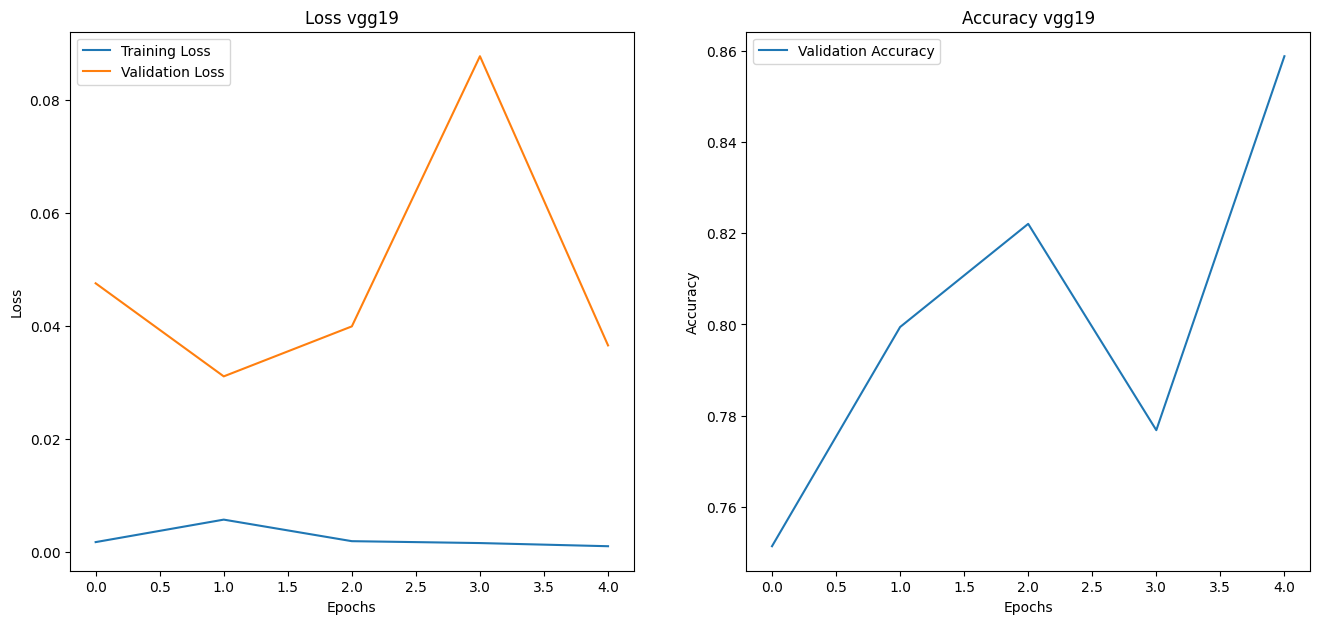

In [150]:
rg_model.plot("vgg19")

#### Métricas guardadas en tensorboard

In [151]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 10302), started 0:09:52 ago. (Use '!kill 10302' to kill it.)

### Cargamos el último modelo guardado

In [172]:
model = vgg19(weights='DEFAULT')
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 2)
model.load_state_dict(torch.load(rg_model.name_model))
model.eval().to('cuda:0')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Ahora se podría testear con otra zona. Puedo sacar algunos glaciares de arg. al ojo.